In [1]:
import os.path
import pickle

import numpy as np
import pandas as pd
from numba import jit
from scipy import stats
from sklearn.preprocessing import StandardScaler
from tqdm import notebook

In [2]:
## load data into np array
def convert_data_format_calms21(data):
    # This is altered to fit with the calms21 data conversion script calms21_convert_to_npy.py
    ## Going through all sequences and creating giant dataframe
    keypoint_names = ['nose', 'ear_left', 'ear_right', 'neck', 'hip_left', 'hip_right', 'tail_base']
    keypoints_idx = pd.MultiIndex.from_product([['resident', 'intruder'], keypoint_names, list('xy')],
                                               names=['animal', 'keypoints', 'coords'])
    #task 1 has only 1 annotator (main key)
    data = data[list(data.keys())[0]]
    #sequence names are the keys of the dictionary
    sequence_names = list(data.keys())
    #sequence_names = list(data["sequences"].keys()) # old code
    collection = []
    targets = []
    for sequence_idx in range(len(sequence_names)):
        sequence_key = sequence_names[sequence_idx]
        single_sequence = data[sequence_key]
        #single_sequence = data["sequences"][sequence_key] # old code
        single_keypoints = single_sequence['keypoints']
        single_keypoints_2d = single_keypoints.reshape(single_keypoints.shape[0],
                                                       single_keypoints.shape[1] *
                                                       single_keypoints.shape[2] *
                                                       single_keypoints.shape[3],
                                                       order='F')
        # convert to dataframe
        df_single_keypoints = pd.DataFrame(single_keypoints_2d, columns=keypoints_idx)
        pose = [ 0,  2,  12, 14, 16, 18, 20, 22, 24, 26,  1,  3,  13, 15, 17, 19, 21, 23, 25, 27]

        collection.append(np.array(df_single_keypoints.iloc[:, pose]))
        # training we have annotations, but testing we do not.
        try:
            single_annotations = single_sequence['annotations']
            targets.append(np.array(single_annotations))
        except:
            pass
    if targets:
        return collection, targets
    else:
        return collection

In [3]:
## FAST NUMBA PROCESSING FUNCTIONS
@jit(nopython=True)
def fast_standardize(data):
    a_ = (data - np.mean(data)) / np.std(data)
    return a_


def fast_nchoose2(n, k):
    a = np.ones((k, n - k + 1), dtype=int)
    a[0] = np.arange(n - k + 1)
    for j in range(1, k):
        reps = (n - k + j) - a[j - 1]
        a = np.repeat(a, reps, axis=1)
        ind = np.add.accumulate(reps)
        a[j, ind[:-1]] = 1 - reps[1:]
        a[j, 0] = j
        a[j] = np.add.accumulate(a[j])
        return a


@jit(nopython=True)
def fast_running_mean(x, N):
    out = np.zeros_like(x, dtype=np.float64)
    dim_len = x.shape[0]
    for i in range(dim_len):
        if N % 2 == 0:
            a, b = i - (N - 1) // 2, i + (N - 1) // 2 + 2
        else:
            a, b = i - (N - 1) // 2, i + (N - 1) // 2 + 1
        a = max(0, a)
        b = min(dim_len, b)
        out[i] = np.mean(x[a:b])
    return out


@jit(nopython=True)
def np_apply_along_axis(func1d, axis, arr):
    assert arr.ndim == 2
    assert axis in [0, 1]
    if axis == 0:
        result = np.empty(arr.shape[1])
        for i in range(len(result)):
            result[i] = func1d(arr[:, i])
    else:
        result = np.empty(arr.shape[0])
        for i in range(len(result)):
            result[i] = func1d(arr[i, :])
    return result


@jit(nopython=True)
def np_mean(array, axis):
    return np_apply_along_axis(np.mean, axis, array)


@jit(nopython=True)
def np_std(array, axis):
    return np_apply_along_axis(np.std, axis, array)


@jit(nopython=True)
def angle_between(vector1, vector2):
    """ Returns the angle in radians between given vectors"""
    v1_u = unit_vector(vector1)
    v2_u = unit_vector(vector2)
    minor = np.linalg.det(
        np.stack((v1_u[-2:], v2_u[-2:]))
    )
    if minor == 0:
        sign = 1
    else:
        sign = -np.sign(minor)
    dot_p = np.dot(v1_u, v2_u)
    dot_p = min(max(dot_p, -1.0), 1.0)
    return sign * np.arccos(dot_p)


@jit(nopython=True)
def unit_vector(vector):
    """ Returns the unit vector of the vector.  """
    return vector / np.linalg.norm(vector)


@jit(nopython=True)
def fast_displacment(data, reduce=False):
    data_length = data.shape[0]
    if reduce:
        displacement_array = np.zeros((data_length, int(data.shape[1] / 10)), dtype=np.float64)
    else:
        displacement_array = np.zeros((data_length, int(data.shape[1] / 2)), dtype=np.float64)
    for r in range(data_length):
        if r < data_length - 1:
            if reduce:
                count = 0
                for c in range(int(data.shape[1] / 2 - 2), data.shape[1], int(data.shape[1] / 2)):
                    displacement_array[r, count] = np.linalg.norm(data[r + 1, c:c + 2] - data[r, c:c + 2])
                    count += 1
            else:
                for c in range(0, data.shape[1], 2):
                    displacement_array[r, int(c / 2)] = np.linalg.norm(data[r + 1, c:c + 2] - data[r, c:c + 2])
    return displacement_array


@jit(nopython=True)
def fast_length_angle(data, index):
    data_length = data.shape[0]
    length_2d_array = np.zeros((data_length, index.shape[1], 2), dtype=np.float64)
    for r in range(data_length):
        for i in range(index.shape[1]):
            ref = index[0, i]
            target = index[1, i]
            length_2d_array[r, i, :] = data[r, ref:ref + 2] - data[r, target:target + 2]
    length_array = np.zeros((data_length, length_2d_array.shape[1]), dtype=np.float64)
    angle_array = np.zeros((data_length, length_2d_array.shape[1]), dtype=np.float64)
    for k in range(length_2d_array.shape[1]):
        for kk in range(data_length):
            length_array[kk, k] = np.linalg.norm(length_2d_array[kk, k, :])
            if kk < data_length - 1:
                try:
                    angle_array[kk, k] = np.rad2deg(
                        angle_between(length_2d_array[kk, k, :], length_2d_array[kk + 1, k, :]))
                except:
                    pass
    return length_array, angle_array


@jit(nopython=True)
def fast_smooth(data, n):
    data_boxcar_avg = np.zeros((data.shape[0], data.shape[1]))
    for body_part in range(data.shape[1]):
        data_boxcar_avg[:, body_part] = fast_running_mean(data[:, body_part], n)
    return data_boxcar_avg


@jit(nopython=True)
def fast_feature_extraction(data, framerate, index, smooth):
    window = np.int(np.round(0.05 / (1 / framerate)) * 2 - 1)
    features = []
    for n in range(len(data)):
        displacement_raw = fast_displacment(data[n])
        length_raw, angle_raw = fast_length_angle(data[n], index)
        if smooth:
            displacement_run_mean = fast_smooth(displacement_raw, window)
            length_run_mean = fast_smooth(length_raw, window)
            angle_run_mean = fast_smooth(angle_raw, window)
            features.append(np.hstack((length_run_mean[1:, :], angle_run_mean[:-1, :], displacement_run_mean[:-1, :])))
        else:
            features.append(np.hstack((length_raw[1:, :], angle_raw[:-1, :], displacement_raw[:-1, :])))
    return features


@jit(nopython=True)
def fast_feature_binning(features, framerate, index):
    binned_features_list = []
    for n in range(len(features)):
        bin_width = int(framerate / 10)
        for s in range(bin_width):
            binned_features = np.zeros((int(features[n].shape[0] / bin_width), features[n].shape[1]), dtype=np.float64)
            for b in range(bin_width + s, features[n].shape[0], bin_width):
                binned_features[int(b / bin_width - 1), 0:index.shape[1]] = np_mean(features[n][(b - bin_width):b,
                                                                                    0:index.shape[1]], 0)
                binned_features[int(b / bin_width - 1), index.shape[1]:] = np.sum(features[n][(b - bin_width):b,
                                                                                  index.shape[1]:], axis=0)
            binned_features_list.append(binned_features)
    return binned_features_list


def bsoid_extract_numba(data, fps):
    smooth = False
    index = fast_nchoose2(int(data[0].shape[1] / 2), 2)
    features = fast_feature_extraction(data, fps, index * 2, smooth)
    binned_features = fast_feature_binning(features, fps, index * 2)
    return binned_features


def feature_extraction(train_datalist, num_train, framerate=120):
    f_integrated = []
    for i in notebook.tqdm(range(num_train)):
        binned_features = bsoid_extract_numba([train_datalist[i]], framerate)
        f_integrated.append(binned_features[0])  # getting only the non-shifted
    features = np.vstack([f_integrated[m] for m in range(len(f_integrated))])
    scaler = StandardScaler()
    scaler.fit(features)
    scaled_features = scaler.transform(features)
    return features, scaled_features

### load dataset


In [4]:
train = np.load('../raw_data/calms21_task1_train.npy', allow_pickle=True).item()
test = np.load('../raw_data/calms21_task1_test.npy', allow_pickle=True).item()

In [5]:
train_datalist, targets_raw = convert_data_format_calms21(train)
len(train_datalist), train_datalist[0].shape, len(targets_raw)

(70, (21364, 20), 70)

## Different bins to estimate the ability to recognize the behavior from a UMAP embedding

In [6]:

framerate = 30
bins_fr = np.arange(3.0, 19.0, 3.0) # bins in the range of 200ms to 600ms
ridiculous_bins_fr = np.array([2, 30, 30*5, 30*10]) # bins that are too small or too large (2 frames is minimum, 30 frames is 1 second, 30*5 is 5 seconds)
bins_fr = np.concatenate([bins_fr, ridiculous_bins_fr])

bins_fr

array([  3.,   6.,   9.,  12.,  15.,  18.,   2.,  30., 150., 300.])

In [7]:
import os
feature_bins = {x: dict(features = [], scaled_features = [],targets = []) for x in bins_fr}

for bin in feature_bins.keys():
    output_path = '../processed_data/features_targets_bin{}.pkl'.format(bin)
    if os.path.exists(output_path):

        try:
            print("bin {} already exists".format(bin))
            with open(output_path, 'rb') as f:
                [features, scaled_features, targets] = pickle.load(f)
                feature_bins[bin]["features"] = features
                feature_bins[bin]["scaled_features"] = scaled_features
                feature_bins[bin]["targets"] = targets
            continue
        except:
            print("bin {} exists but is corrupted".format(bin))


    print("bin: ", bin)
    num2skip = int(bin)
    framerate = num2skip*10 # so it works with the function
    features, scaled_features = feature_extraction(train_datalist, len(train_datalist), framerate)
    feature_bins[bin]['features'] = features
    feature_bins[bin]['scaled_features'] = scaled_features

    targets_ls = []
    for i in range(len(train_datalist)):
        targets_not_matching = np.hstack(
            [stats.mode(targets_raw[i][(num2skip - 1) + num2skip * n:(num2skip - 1) + num2skip * n + num2skip])[0]
             for n in range(len(targets_raw[i]))])
        # features are skipped so if it's not multiple of 12, we discard the final few targets
        targets_matching_features = targets_raw[i][(num2skip - 1):-1:num2skip]
        targets_ls.append(targets_not_matching[:targets_matching_features.shape[0]])
    targets = np.hstack(targets_ls)
    feature_bins[bin]['targets'] = targets
    print(100 * '*')
    print(f'Behaviors downsampled into {targets.shape[0]} representatives by mode')
    print(f'each with {scaled_features.shape[1]} features')
    print(100 * '*')
    with open(output_path, 'wb') as f:
        pickle.dump([features, scaled_features, targets], f)





bin 3.0 already exists
bin 6.0 already exists
bin 9.0 already exists
bin 12.0 already exists
bin 15.0 already exists
bin 18.0 already exists
bin 2.0 already exists
bin 30.0 already exists
bin 150.0 already exists
bin 300.0 already exists


## Let's embedd them with UMAP

In [8]:
import umap
import matplotlib.pyplot as plt
import numpy as np

for bin in feature_bins.keys():
    print("bin: ", bin)
    output_path = '../processed_data/embeddings_bin{}.pkl'.format(bin)
    if os.path.exists(output_path):

        print("bin {} already exists".format(bin))
        try:
            with open(output_path, 'rb') as f:
                embeddings_ = pickle.load(f)
                feature_bins[bin]['embeddings'] = embeddings_
            continue
        except:
            print("bin {} exists but is corrupted".format(bin))

    features_train = feature_bins[bin]['scaled_features']
    ## first generate embedding of all samples
    reducer = umap.UMAP(n_neighbors=60, n_components=2, min_dist=0.0, random_state=42)
    embeddings_ = reducer.fit_transform(features_train)
    feature_bins[bin]['embeddings'] = embeddings_
    with open(output_path, 'wb') as f:
        pickle.dump(embeddings_, f)


C:\Users\JSchw\anaconda3\envs\asoid_analysis\lib\site-packages\umap\distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
C:\Users\JSchw\anaconda3\envs\asoid_analysis\lib\site-packages\umap\distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
C:\Users\JSchw\anaconda3\envs\asoid_analysis\lib\site-packages\umap\dist

bin:  3.0
bin 3.0 already exists
bin:  6.0
bin 6.0 already exists
bin:  9.0
bin 9.0 already exists
bin:  12.0
bin 12.0 already exists
bin:  15.0
bin 15.0 already exists
bin:  18.0
bin 18.0 already exists
bin:  2.0
bin 2.0 already exists
bin:  30.0
bin 30.0 already exists
bin:  150.0
bin 150.0 already exists
bin:  300.0
bin 300.0 already exists


C:\Users\JSchw\anaconda3\envs\asoid_analysis\lib\site-packages\umap\umap_.py:660: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()


# plot embeddings

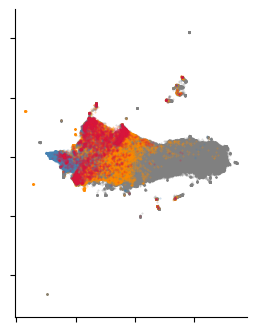

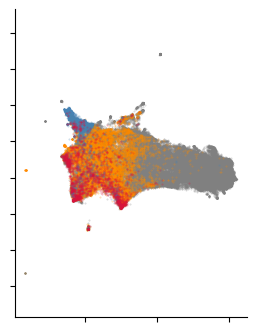

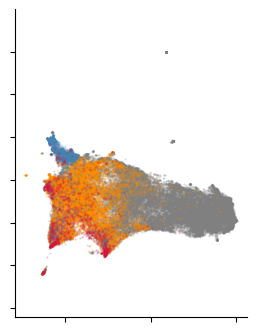

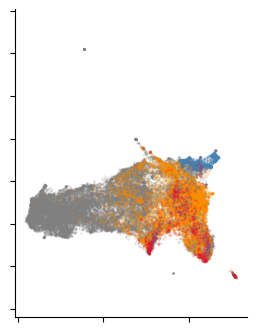

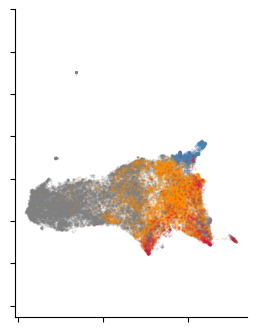

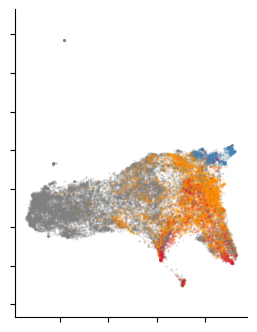

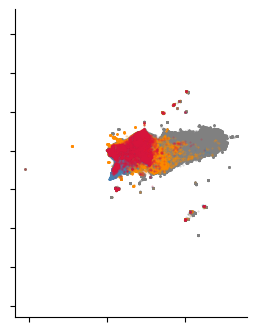

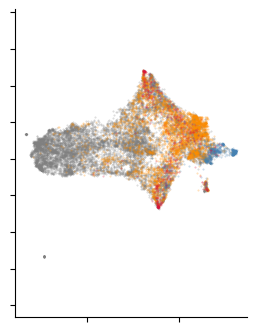

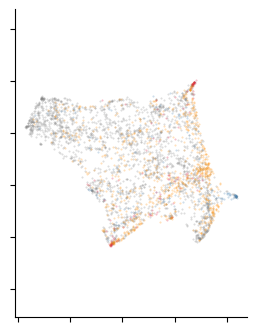

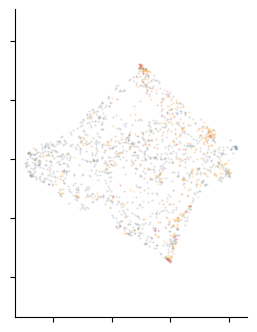

In [23]:
behavior_types = ['Other',  'Investigation', 'Mount', 'Attack']
cmap = ['crimson', 'darkorange', 'steelblue', 'k']

for bin in feature_bins.keys():
    embeddings_ = feature_bins[bin]['embeddings']
    targets_train = feature_bins[bin]['targets']
    fig = plt.figure(figsize=(3, 4))
    ax = fig.add_subplot()
    for b in [3, 1, 2, 0]:
        if b == 3:
            idx_b_embed = np.where(targets_train==int(b))[0]
            ax.scatter(embeddings_[idx_b_embed, 0],
                       embeddings_[idx_b_embed, 1],
                       s=0.2, alpha=0.3, c='grey'
                       , label=behavior_types[int(b)])
            ax.set_xticklabels('')
            ax.set_yticklabels('')
        else:
            idx_b_embed = np.where(targets_train==int(b))[0]
            ax.scatter(embeddings_[idx_b_embed, 0],
                       embeddings_[idx_b_embed, 1],
                       s=0.2,
                       alpha=0.3,
                       c=cmap[int(b)]
                       , label=behavior_types[int(b)])
            ax.set_xticklabels('')
            ax.set_yticklabels('')
        #ax.legend(behavior_types)
        #ax.set_xlim([0, 13])
        #ax.set_ylim([-5, 8])
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)

    #plt.title('UMAP embedding of all samples (Feature bin = {} ms / {} frames)'.format(int(1/30*bin *1000), bin))
    plt.axis('equal')
    #plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    plt.savefig('../plots/Task1_UMAP_embedding_bin{}.png'.format(bin), dpi=300, bbox_inches='tight')
    plt.show()

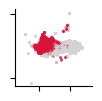

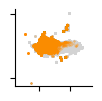

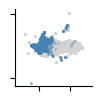

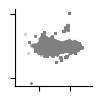

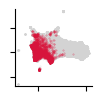

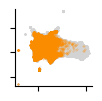

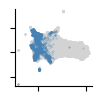

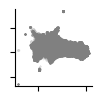

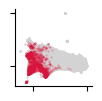

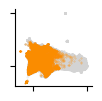

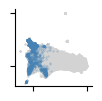

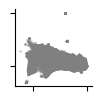

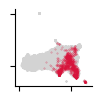

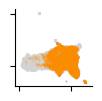

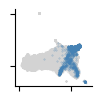

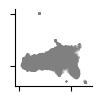

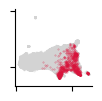

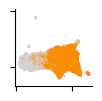

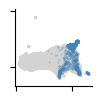

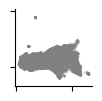

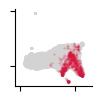

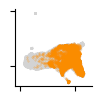

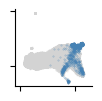

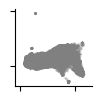

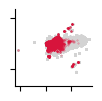

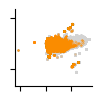

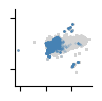

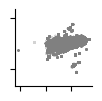

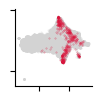

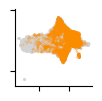

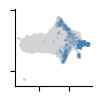

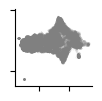

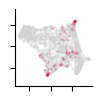

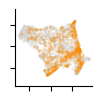

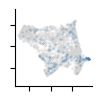

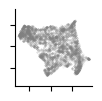

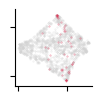

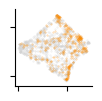

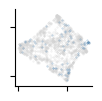

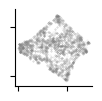

In [20]:
plt.style.use('default')
behavior_types = ['Attack', 'Investigation', 'Mount', 'Other']
for bin in feature_bins.keys():
    embeddings_ = feature_bins[bin]['embeddings']
    targets_train = feature_bins[bin]['targets']
    for b in np.unique(targets_train):
        if b == 3:
            fig, ax = plt.subplots(1, 1, figsize=(1, 1))
            idx_b_embed = np.where(targets_train==int(b))[0]
            idx_not_b = np.where(targets_train!=int(b))[0]
            ax.scatter(embeddings_[idx_not_b, 0],
                       embeddings_[idx_not_b, 1],
                       s=0.1, alpha=0.5, c='lightgray')
            ax.scatter(embeddings_[idx_b_embed, 0],
                       embeddings_[idx_b_embed, 1],
                       s=0.1, alpha=0.5, c='gray')
        else:
            fig, ax = plt.subplots(1, 1, figsize=(1, 1))
            idx_b_embed = np.where(targets_train==int(b))[0]
            idx_not_b = np.where(targets_train!=int(b))[0]
            ax.scatter(embeddings_[idx_not_b, 0],
                       embeddings_[idx_not_b, 1],
                       s=0.1, alpha=0.5, c='lightgray')
            ax.scatter(embeddings_[idx_b_embed, 0],
                       embeddings_[idx_b_embed, 1],
                       s=0.1, alpha=0.5, c=cmap[int(b)])
        #ax.set_title(behavior_types[int(b)])
        ax.set_xticklabels('')
        ax.set_yticklabels('')
        #ax.set_xlim([0, 13])
        #ax.set_ylim([-5, 8])
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        plt.axis('equal')
        plt.savefig('../plots/Task1_UMAP_embedding_bin{}_{}.png'.format(bin, behavior_types[int(b)]), dpi=300, bbox_inches='tight',  transparent=True)
        plt.show()



# confusion matrix between hdbscan and annotation

# PCA on the features

In [11]:
from sklearn.decomposition import PCA



bin_selection = [6.0, 12.0, 30.0]
for bin in bin_selection:
    print("bin: {}".format(bin))
    pca = PCA(n_components=2, random_state=42)
    pca.fit(feature_bins[bin]['scaled_features'])
    feature_bins[bin]['PCA'] = pca.transform(feature_bins[bin]['scaled_features'])


bin: 6.0
bin: 12.0
bin: 30.0


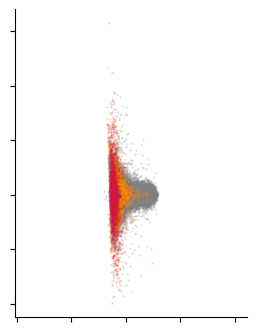

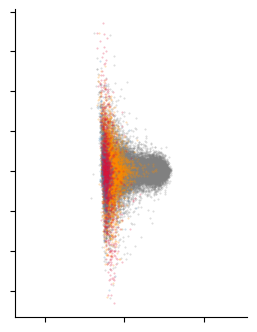

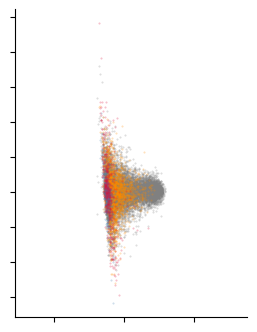

In [71]:
behavior_types = ['Other',  'Investigation', 'Mount', 'Attack']
cmap = ['crimson', 'darkorange', 'steelblue', 'k']

for bin in bin_selection:
    embeddings_ = feature_bins[bin]['PCA']
    targets_train = feature_bins[bin]['targets']
    fig = plt.figure(figsize=(3, 4))
    ax = fig.add_subplot()
    for b in [3, 1, 2, 0]:
        if b == 3:
            idx_b_embed = np.where(targets_train==int(b))[0]
            ax.scatter(embeddings_[idx_b_embed, 0],
                       embeddings_[idx_b_embed, 1],
                       s=0.2, alpha=0.3, c='grey'
                       , label=behavior_types[int(b)])
            ax.set_xticklabels('')
            ax.set_yticklabels('')
        else:
            idx_b_embed = np.where(targets_train==int(b))[0]
            ax.scatter(embeddings_[idx_b_embed, 0],
                       embeddings_[idx_b_embed, 1],
                       s=0.2,
                       alpha=0.3,
                       c=cmap[int(b)]
                       , label=behavior_types[int(b)])
            ax.set_xticklabels('')
            ax.set_yticklabels('')
        #ax.legend(behavior_types)
        #ax.set_xlim([0, 13])
        #ax.set_ylim([-5, 8])
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)

    #plt.title('UMAP embedding of all samples (Feature bin = {} ms / {} frames)'.format(int(1/30*bin *1000), bin))
    plt.axis('equal')
    #plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    plt.savefig('../plots/Task1_PCA_embedding_bin{}.png'.format(bin), dpi=300, bbox_inches='tight')
    plt.show()

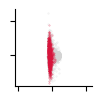

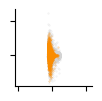

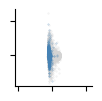

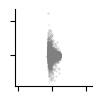

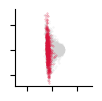

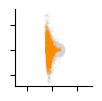

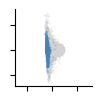

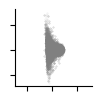

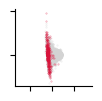

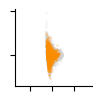

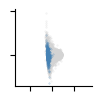

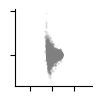

In [21]:
plt.style.use('default')
behavior_types = ['Attack', 'Investigation', 'Mount', 'Other']
for bin in bin_selection:
    embeddings_ = feature_bins[bin]['PCA']
    targets_train = feature_bins[bin]['targets']
    for b in np.unique(targets_train):
        if b == 3:
            fig, ax = plt.subplots(1, 1, figsize=(1, 1))
            idx_b_embed = np.where(targets_train==int(b))[0]
            idx_not_b = np.where(targets_train!=int(b))[0]
            ax.scatter(embeddings_[idx_not_b, 0],
                       embeddings_[idx_not_b, 1],
                       s=0.1, alpha=0.5, c='lightgray')
            ax.scatter(embeddings_[idx_b_embed, 0],
                       embeddings_[idx_b_embed, 1],
                       s=0.1, alpha=0.5, c='gray')
        else:
            fig, ax = plt.subplots(1, 1, figsize=(1, 1))
            idx_b_embed = np.where(targets_train==int(b))[0]
            idx_not_b = np.where(targets_train!=int(b))[0]
            ax.scatter(embeddings_[idx_not_b, 0],
                       embeddings_[idx_not_b, 1],
                       s=0.1, alpha=0.5, c='lightgray')
            ax.scatter(embeddings_[idx_b_embed, 0],
                       embeddings_[idx_b_embed, 1],
                       s=0.1, alpha=0.5, c=cmap[int(b)])
        #ax.set_title(behavior_types[int(b)])
        ax.set_xticklabels('')
        ax.set_yticklabels('')
        #ax.set_xlim([0, 13])
        #ax.set_ylim([-5, 8])
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        plt.axis('equal')
        plt.savefig('../plots/Task1_PCA_embedding_bin{}_{}.png'.format(bin, behavior_types[int(b)]), dpi=300, bbox_inches='tight', transparent=True)
        plt.show()

# tSNE

In [13]:
from sklearn.manifold import TSNE

for bin in bin_selection:
    print("bin: {}".format(bin))
    X = feature_bins[bin]['scaled_features']
    X_embedded = TSNE(n_components=2, n_jobs = -1).fit_transform(X)
    feature_bins[bin]['TSNE'] = X_embedded

bin: 6.0
bin: 12.0
bin: 30.0


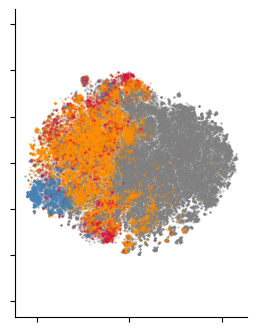

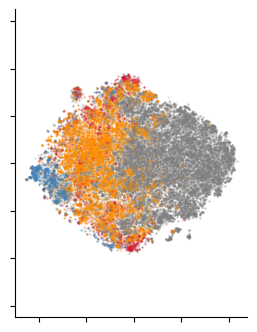

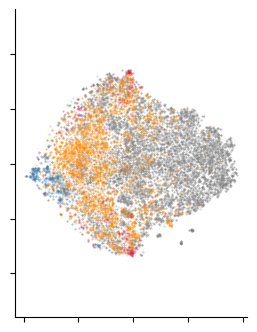

In [75]:
for bin in bin_selection:
    embeddings_ = feature_bins[bin]['TSNE']
    targets_train = feature_bins[bin]['targets']
    fig = plt.figure(figsize=(3, 4))
    ax = fig.add_subplot()
    for b in [3, 1, 2, 0]:
        if b == 3:
            idx_b_embed = np.where(targets_train==int(b))[0]
            ax.scatter(embeddings_[idx_b_embed, 0],
                       embeddings_[idx_b_embed, 1],
                       s=0.2, alpha=0.3, c='grey'
                       , label=behavior_types[int(b)])
            ax.set_xticklabels('')
            ax.set_yticklabels('')
        else:
            idx_b_embed = np.where(targets_train==int(b))[0]
            ax.scatter(embeddings_[idx_b_embed, 0],
                       embeddings_[idx_b_embed, 1],
                       s=0.2,
                       alpha=0.3,
                       c=cmap[int(b)]
                       , label=behavior_types[int(b)])
            ax.set_xticklabels('')
            ax.set_yticklabels('')
        #ax.legend(behavior_types)
        #ax.set_xlim([0, 13])
        #ax.set_ylim([-5, 8])
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)

    #plt.title('UMAP embedding of all samples (Feature bin = {} ms / {} frames)'.format(int(1/30*bin *1000), bin))
    plt.axis('equal')
    #plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    plt.savefig('../plots/Task1_TSNE_embedding_bin{}.png'.format(bin), dpi=300, bbox_inches='tight')
    plt.show()

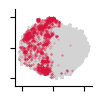

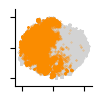

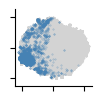

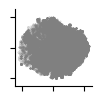

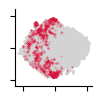

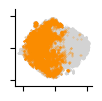

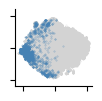

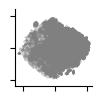

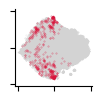

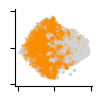

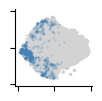

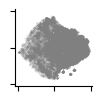

In [22]:
plt.style.use('default')
for bin in bin_selection:
    embeddings_ = feature_bins[bin]['TSNE']
    targets_train = feature_bins[bin]['targets']
    for b in np.unique(targets_train):
        if b == 3:
            fig, ax = plt.subplots(1, 1, figsize=(1, 1))
            idx_b_embed = np.where(targets_train==int(b))[0]
            idx_not_b = np.where(targets_train!=int(b))[0]
            ax.scatter(embeddings_[idx_not_b, 0],
                       embeddings_[idx_not_b, 1],
                       s=0.1, alpha=0.5, c='lightgray')
            ax.scatter(embeddings_[idx_b_embed, 0],
                       embeddings_[idx_b_embed, 1],
                       s=0.1, alpha=0.5, c='gray')
        else:
            fig, ax = plt.subplots(1, 1, figsize=(1, 1))
            idx_b_embed = np.where(targets_train==int(b))[0]
            idx_not_b = np.where(targets_train!=int(b))[0]
            ax.scatter(embeddings_[idx_not_b, 0],
                       embeddings_[idx_not_b, 1],
                       s=0.1, alpha=0.5, c='lightgray')
            ax.scatter(embeddings_[idx_b_embed, 0],
                       embeddings_[idx_b_embed, 1],
                       s=0.1, alpha=0.5, c=cmap[int(b)])
        #ax.set_title(behavior_types[int(b)])
        ax.set_xticklabels('')
        ax.set_yticklabels('')
        #ax.set_xlim([0, 13])
        #ax.set_ylim([-5, 8])
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        plt.axis('equal')
        plt.savefig('../plots/Task1_TSNE_embedding_bin{}_{}.png'.format(bin, behavior_types[int(b)]), dpi=300, bbox_inches='tight', transparent=True)
        plt.show()